In [1]:
import ast
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
from collections import defaultdict, Counter
from PIL import Image, ImageDraw, ImageFont


In [2]:
def hardware_check():

    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"GPU is available!")
        print(f"  -> GPU - {torch.cuda.get_device_name()}")
        print(f"  -> Total Memory: {torch.cuda.get_device_properties().total_memory / 1024**3:.2f} GB")
    else:
        device = torch.device("cpu")
        print("GPU is not available, using CPU.")
        print("\nCPU Information:")

        cpu_model = os.popen("cat /proc/cpuinfo | grep \"model name\" | uniq").read().strip()
        print(f"CPU Model: {cpu_model}")
        print(f"Number of CPU cores: {os.cpu_count()}")

    return device

device = hardware_check()
print(f"\nUsing {device} for computation")

GPU is available!
  -> GPU - NVIDIA RTX 4000 Ada Generation
  -> Total Memory: 19.57 GB

Using cuda for computation


In [3]:
# Percorso locale al dataset
dataset_path = 'CCPD2019' 

if os.path.exists(dataset_path):
    print("Dataset trovato in locale!")
else:
    print(f"Dataset non trovato al percorso: {dataset_path}")


Dataset trovato in locale!


In [4]:
# Directory Tree Limitato per Immagini JPG e PNG

def print_directory_tree_jpg_png_limited(path, prefix="", is_last=True, max_image_files=5, is_root=False):

    connector = "└── " if is_last else "├── "

    if is_root:
        print(path)
    else:
        print(prefix + connector + os.path.basename(path))

    new_prefix = prefix + ("    " if is_last else "│   ")

    if os.path.isdir(path):
        items = sorted(os.listdir(path))
        full_paths = [os.path.join(path, item) for item in items]

        dirs = [item for item in full_paths if os.path.isdir(item)]
        files = [item for item in full_paths if os.path.isfile(item)]

        for i, d in enumerate(dirs):
            is_last_dir = (i == len(dirs) - 1 and not files)
            print_directory_tree_jpg_png_limited(d, new_prefix, is_last_dir, max_image_files)

        # Se la cartella contiene immagini jpg o png, la stampa è limitata
        image_files = [f for f in files if f.lower().endswith((".jpg", ".png"))]
        if image_files:
            limited_images = image_files[:max_image_files]
            if len(image_files) > max_image_files:
                limited_images.append("...")

            for i, f in enumerate(limited_images):
                is_last_file = i == len(limited_images) - 1
                if f == "...":
                    print(new_prefix + "└── ...")
                else:
                    print(new_prefix + ("└── " if is_last_file else "├── ") + os.path.basename(f))
        else:
            # Se sono presenti altri file (non jpg o png): vengono mostrati tutti
            for i, f in enumerate(files):
                is_last_file = i == len(files) - 1
                print(new_prefix + ("└── " if is_last_file else "├── ") + os.path.basename(f))

print("CCPD - Directory Tree:\n")
print_directory_tree_jpg_png_limited(dataset_path, is_root=True)


CCPD - Directory Tree:

CCPD2019
    ├── ccpd_base
    │   ├── 00205459770115-90_85-352&516_448&547-444&547_368&549_364&517_440&515-0_0_22_10_26_29_24-128-7.jpg
    │   ├── 00221264367816-91_91-283&519_381&553-375&551_280&552_285&514_380&513-0_0_7_26_17_33_29-95-9.jpg
    │   ├── 00223060344828-90_89-441&517_538&546-530&552_447&548_447&512_530&516-0_0_13_16_33_30_33-148-14.jpg
    │   ├── 00224137931034-90_87-351&564_451&606-440&599_362&600_359&572_437&571-0_0_3_21_30_28_24-88-5.jpg
    │   ├── 00227490421455-90_88-341&443_436&482-437&479_338&486_335&452_434&445-0_0_9_33_33_29_28-128-12.jpg
    │   └── ...
    ├── ccpd_blur
    │   ├── 0019-1_1-340&500_404&526-404&524_340&526_340&502_404&500-0_0_11_26_25_28_17-66-3.jpg
    │   ├── 0022-0_1-360&474_433&500-432&500_360&499_361&474_433&475-0_0_20_24_26_27_10-143-5.jpg
    │   ├── 0022-0_2-289&482_362&508-361&508_289&508_290&482_362&482-0_0_3_11_31_25_33-94-7.jpg
    │   ├── 0022-0_4-337&385_411&410-411&410_339&410_337&385_409&385-0_0_13_2

In [5]:
# Funzione per leggere e mostrare le prime righe di un file txt
def show_txt_head(txt_file, num_lines=5):

    print(f"Prime {num_lines} righe di {txt_file}:")
    with open(txt_file, 'r') as f:
        for _ in range(num_lines):
            line = f.readline().strip()
            if not line:
                break
            print(line)
    print() 

# Percorsi ai file txt di train, validation e test
train_txt_path = os.path.join(dataset_path, 'splits', 'train.txt')
val_txt_path = os.path.join(dataset_path, 'splits', 'val.txt')
test_txt_path = os.path.join(dataset_path, 'splits', 'test.txt')

# Mostra prime righe dei file train, val e test
show_txt_head(train_txt_path, num_lines=5)
show_txt_head(val_txt_path, num_lines=5)
show_txt_head(test_txt_path, num_lines=5)


Prime 5 righe di CCPD2019/splits/train.txt:
ccpd_base/0092816091954-94_82-181&490_358&548-363&554_189&540_190&484_364&498-0_0_28_29_16_29_32-133-13.jpg
ccpd_base/0104418103448-91_84-329&442_511&520-515&519_340&508_326&447_501&458-0_0_33_18_25_26_26-166-27.jpg
ccpd_base/023275862069-90_86-173&473_468&557-485&563_189&555_187&469_483&477-0_0_2_27_9_26_24-178-36.jpg
ccpd_base/0344827586207-92_75-255&369_564&505-560&520_256&454_239&349_543&415-0_0_11_32_27_27_33-37-19.jpg
ccpd_base/0144516283524-97_72-90&538_280&616-278&629_95&595_85&525_268&559-0_0_19_30_28_32_19-74-41.jpg

Prime 5 righe di CCPD2019/splits/val.txt:
ccpd_base/0219683908046-89_84-126&620_414&687-414&688_144&694_122&619_392&613-0_0_1_25_25_26_3-36-29.jpg
ccpd_base/0384159482759-87_93-367&427_654&550-656&527_369&554_379&441_666&414-0_0_13_19_33_27_24-95-81.jpg
ccpd_base/03-92_88-249&560_561&670-561&668_265&654_266&562_562&576-0_0_10_8_30_26_28-114-73.jpg
ccpd_base/0283908045977-91_84-150&476_476&577-482&585_148&572_139&473_473

In [6]:
# Analisi intero dataset

def inspect_image(image_path):
    try:
        img = Image.open(image_path)
        arr = np.array(img)
        return {
            "mode": img.mode,
            "dtype": str(arr.dtype),
            "shape": arr.shape,
            "min": arr.min(),
            "max": arr.max()
        }
    except Exception:
        return None

def inspect_txt_images(txt_path, data_path, name=""):
    print(f"Analisi del dataset: {name}")
    
    with open(txt_path, 'r') as f:
        lines = f.read().splitlines()

    stats = defaultdict(Counter)
    valid_count = 0

    for rel_path in lines:
        abs_path = os.path.join(data_path, rel_path)
        info = inspect_image(abs_path)

        if info is None:
            continue

        valid_count += 1

        stats["mode"][info["mode"]] += 1
        stats["dtype"][info["dtype"]] += 1
        stats["shape"][str(info["shape"])] += 1

    print(f"Immagini analizzate: {valid_count} su {len(lines)}")
    print(f"Statistiche immagini per dataset '{name}':")

    print("Mode:", dict(stats["mode"]))
    print("Dtype:", dict(stats["dtype"]))
    print("Shape:", dict(stats["shape"]))

inspect_txt_images(train_txt_path, dataset_path, name="Training Set")
# inspect_txt_images(val_txt_path, dataset_path, name="Validation Set")
# inspect_txt_images(test_txt_path, dataset_path, name="Test Set")



Analisi del dataset: Training Set
Immagini analizzate: 100000 su 100000
Statistiche immagini per dataset 'Training Set':
Mode: {'RGB': 100000}
Dtype: {'uint8': 100000}
Shape: {'(1160, 720, 3)': 100000}


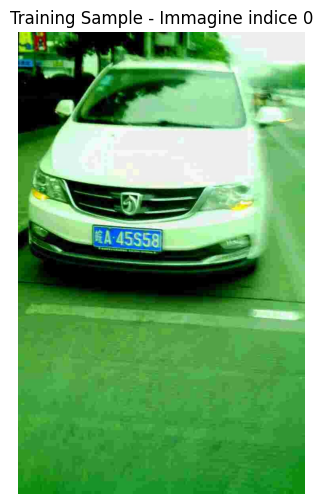

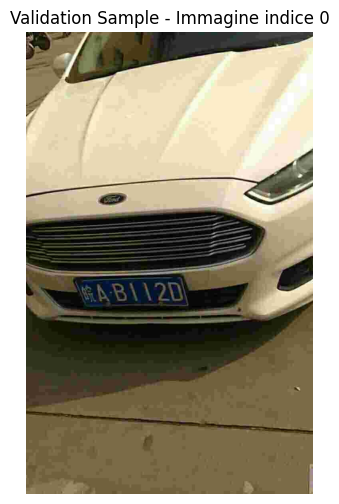

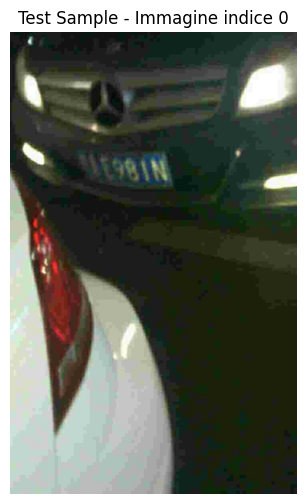

In [10]:
def show_first_existing_ccpd_sample(txt_file, dataset_path, title="Sample"):

    with open(txt_file, 'r') as f:
        lines = f.read().splitlines()
    
    for idx, img_rel_path in enumerate(lines):
        img_path = os.path.join(dataset_path, img_rel_path)
        if os.path.isfile(img_path):
            img = Image.open(img_path)
            plt.figure(figsize=(8,6))
            plt.imshow(img)
            plt.title(f"{title} - Immagine indice {idx}")
            plt.axis('off')
            plt.show()
            return 
    
    print(f"Nessuna immagine trovata valida in {txt_file}")

# Prima immagine valida da train, val e test
show_first_existing_ccpd_sample(train_txt_path, dataset_path, title="Training Sample")
show_first_existing_ccpd_sample(val_txt_path, dataset_path, title="Validation Sample")
show_first_existing_ccpd_sample(test_txt_path, dataset_path, title="Test Sample")


In [11]:
def decode_plate(plate_str):
    provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
    alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'O']
    # Ads non include "O" come cifra, è un segno di "assenza" di carattere
    ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    
    # Codifica l'indice dei caratteri
    indices = list(map(int, plate_str.split('_')))
    
    # Prima parte: provincia
    prov = provinces[indices[0]] if indices[0] < len(provinces) else 'O'
    
    # Seconda parte: lettera alfabetica
    alpha = alphabets[indices[1]] if indices[1] < len(alphabets) else 'O'
    
    # Terza parte: caratteri alfanumerici
    ads_str = ''.join(ads[i] if i < len(ads) else 'O' for i in indices[2:])
    
    return prov + alpha + ads_str


def parse_filename(filename):
    name = os.path.splitext(filename)[0]
    parts = name.split('-', maxsplit=6)
    if len(parts) != 7:
        raise ValueError(f"Filename non conforme: {filename}")
    
    bbox = None
    vertices = None

    try:
        leftup_str, rightdown_str = parts[2].split('_')
        x_min, y_min = map(int, leftup_str.split('&'))
        x_max, y_max = map(int, rightdown_str.split('&'))
        bbox = [x_min, y_min, x_max, y_max]
    except Exception:
        pass

    try:
        vertices = [list(map(int, v.split('&'))) for v in parts[3].split('_')]
    except Exception:
        pass

    plate_str = parts[4]
    annotation = decode_plate(plate_str)
    encoded_label = list(map(int, plate_str.split('_')))

    brightness = int(parts[5]) if parts[5].isdigit() else None
    blurriness = int(parts[6]) if parts[6].isdigit() else None

    return {
        'area': parts[0],
        'tilt': parts[1],
        'bbox': bbox,
        'vertices': vertices,
        'annotation': annotation,
        'encoded_label': encoded_label,
        'brightness': brightness,
        'blurriness': blurriness
    }

def create_csv_from_txt(txt_path, dataset_path, csv_output_path):
    with open(txt_path, 'r') as f:
        lines = f.read().splitlines()

    data = []
    for rel_path in lines:
        filename = os.path.basename(rel_path)
        try:
            parsed = parse_filename(filename)
            data.append({
                'image_path': rel_path,
                'area': parsed['area'],
                'tilt': parsed['tilt'],
                'bbox': parsed['bbox'],
                'vertices': parsed['vertices'],
                'annotation': parsed['annotation'],
                'encoded_label': parsed['encoded_label'],
                'brightness': parsed['brightness'],
                'blurriness': parsed['blurriness']
            })
        except Exception as e:
            print(f"Errore parsing {filename}: {e}")

    df = pd.DataFrame(data)
    df.to_csv(csv_output_path, index=False)
    print(f"CSV salvato: {csv_output_path}")


In [12]:
create_csv_from_txt(train_txt_path, dataset_path, 'train.csv')
create_csv_from_txt(val_txt_path, dataset_path, 'val.csv')
create_csv_from_txt(test_txt_path, dataset_path, 'test.csv')

CSV salvato: train.csv
CSV salvato: val.csv
CSV salvato: test.csv


Mostro immagine: ccpd_base/0092816091954-94_82-181&490_358&548-363&554_189&540_190&484_364&498-0_0_28_29_16_29_32-133-13.jpg


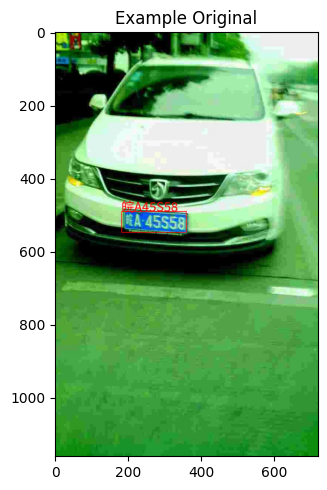

Mostro immagine: ccpd_base/0104418103448-91_84-329&442_511&520-515&519_340&508_326&447_501&458-0_0_33_18_25_26_26-166-27.jpg


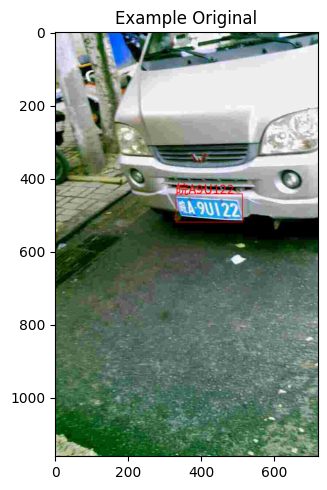

In [ ]:

def plot_plate_sample(csv_row, base_path, title_prefix=""):
    img_rel_path = csv_row['image_path']
    encoded_label = ast.literal_eval(csv_row['encoded_label'])  # [index1, index2, ..., index7]
    bbox = ast.literal_eval(csv_row['bbox'])          # [x1, y1, x2, y2]

    license_plate = decode_plate(encoded_label)

    img_path = os.path.join(base_path, img_rel_path)
    image = Image.open(img_path).convert("RGB")

    fig, axes = plt.subplots(1, 1, figsize=(12, 5))

    font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc'  # For displaying text in Chinese
    font_prop = fm.FontProperties(fname=font_path)  # Usa fm.FontProperties per il font

    try:
        font = ImageFont.truetype(font_path, 35) 
    except IOError:
        font = ImageFont.load_default()

    # Bounding box sull'immagine originale
    draw = ImageDraw.Draw(image)
    draw.rectangle(bbox, outline="red", width=2)
    
    # Label sopra la bounding box
    label_x = bbox[0] 
    label_y = bbox[1] - 40 

    draw.text((label_x, label_y), license_plate, font=font, fill="red") 

    axes.imshow(image)
    axes.set_title(f"{title_prefix} Dataset")

    plt.tight_layout()
    plt.show()

def show_two_examples_from_csv_using_bbox(csv_path, dataset_path, n=2):

    df = pd.read_csv(csv_path)
    
    for idx, row in df.head(n).iterrows():
        rel_path = row['image_path']
        abs_path = os.path.join(dataset_path, rel_path)
        
        try:
            bbox = ast.literal_eval(row['bbox']) if pd.notna(row['bbox']) else None
        except Exception:
            bbox = None
        
        annotation = row['annotation'] if 'annotation' in row else None
        
        print(f"Mostro immagine: {rel_path}")
        plot_plate_sample(row, dataset_path, title_prefix="Example")

# Esempio di uso
csv_path = 'train.csv' 

show_two_examples_from_csv_using_bbox(csv_path, dataset_path, n=2)


In [19]:
# Questa funzione aggiunge i file della cartella weather al file test.txt (non ancora presenti)

def append_files_to_test(txt_path, source_path, category_name=None):
    """
    Aggiunge i file contenuti in source_path al file test.txt con prefisso 'category_name/'.
    Non aggiunge file già presenti nel test.txt.
    
    Parametri:
    - txt_path: path al test.txt
    - source_path: cartella da cui leggere i file
    - category_name: nome prefisso (se None usa nome cartella finale)
    """
    if category_name is None:
        category_name = os.path.basename(os.path.normpath(source_path))

    # Ottieni la lista dei file presenti nel file txt
    existing_files = set()
    if os.path.exists(txt_path):
        with open(txt_path, 'r') as f:
            existing_files = set(f.read().splitlines())  # Carica le righe esistenti in un set

    # Elenco dei file da aggiungere
    files = [f for f in os.listdir(source_path) if os.path.isfile(os.path.join(source_path, f))]
    print(f"Trovati {len(files)} file in {source_path}")

    # Aggiungi solo i file non ancora presenti nel test.txt
    new_files = []
    with open(txt_path, 'a') as f:
        for file_name in files:
            relative_path = f"{category_name}/{file_name}"
            if relative_path not in existing_files:
                f.write(relative_path + '\n')
                new_files.append(relative_path)

    print(f"Aggiunti {len(new_files)} nuovi file a {txt_path}")

# Esegui l'operazione
append_files_to_test('test.txt', 'CCPD2019/ccpd_weather')


Trovati 9999 file in CCPD2019/ccpd_weather
Aggiunti 9999 nuovi file a test.txt


In [ ]:
# Questa funzione divide il file test.csv in più file CSV, uno per ogni categoria presente nel percorso delle immagini.

def split_test_csv_by_directory(test_csv_path, output_dir):
    categories = ['ccpd_blur', 'ccpd_challenge', 'ccpd_db', 'ccpd_fn',
                  'ccpd_rotate', 'ccpd_tilt', 'ccpd_weather']

    df = pd.read_csv(test_csv_path)
    os.makedirs(output_dir, exist_ok=True)

    for cat in categories:
        filtered_df = df[df['image_path'].str.split('/').str[0] == cat]
        csv_path = os.path.join(output_dir, f"{cat}.csv")
        filtered_df.to_csv(csv_path, index=False)
        print(f"Creato {csv_path} con {len(filtered_df)} immagini.")

split_test_csv_by_directory('test.csv',"./csv_splits")


Creato ./csv_splits/ccpd_blur.csv con 20611 immagini.
Creato ./csv_splits/ccpd_challenge.csv con 50003 immagini.
Creato ./csv_splits/ccpd_db.csv con 10132 immagini.
Creato ./csv_splits/ccpd_fn.csv con 20967 immagini.
Creato ./csv_splits/ccpd_rotate.csv con 10053 immagini.
Creato ./csv_splits/ccpd_tilt.csv con 30216 immagini.
Creato ./csv_splits/ccpd_weather.csv con 0 immagini.
